<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2021/blob/master/08-ensembles/Ensembles_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


dataset = fetch_california_housing()

data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

print(len(data))
data.head(10)

20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [2]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

This data contains 2 spacial features: `['Longitude', 'Latitude']`:

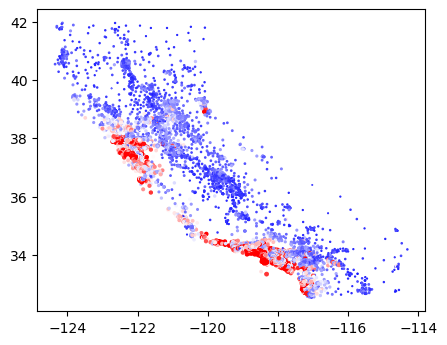

In [3]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(data.Longitude, data.Latitude, s=data.target, c=data.target, cmap='bwr');

(Compare this plot with the map of California: https://en.wikipedia.org/wiki/California)

A kNN model might be quite reasonable to use on this 2D subspace.

Let's first divide our data into train and test:

In [4]:
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


 - Build a kNN regressor on the `Longitude` and `Latitude` features (**0.5 point**)
 - Build a random forest regressor on the rest of the features (**0.5 point**)
 - Build a stacking regressor (`sklearn.ensemble.StackingRegressor`) with 5-fold cross-val-predict using the two models above as the base models and a linear regression model as the final (aggregating) estimator. Don't forget to optimize hyper-parameters of your models. (**4 points**)
 - Compare the test MSE losses of the 3 models above, leave a comment (**1 point**)
 

Make sure to have a look at the documentation: 
https://scikit-learn.org/stable/modules/ensemble.html#stacking

You can make a pipeline (`sklearn.pipeline.make_pipeline`) with a `ColumnTransformer` (`sklearn.compose.make_column_transformer`) and a regression model (knn or random forest), where the `ColumnTransformer` will select the desired columns from the dataset (see the docs for the column transformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html).

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [70]:
# task 1
knn = KNeighborsRegressor()
knn.fit(X_train[["Longitude", "Latitude"]], y_train)
print("knn_train_score: " + str(knn.score(X_train[["Longitude", "Latitude"]], y_train)))
print("knn_test_score: " + str(knn.score(X_test[["Longitude", "Latitude"]], y_test)))

# task 2
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train.drop(["Longitude", "Latitude"], axis=1), y_train)
print("rf_train_score: " + str(rf.score(X_train.drop(["Longitude", "Latitude"], axis=1), y_train))) # doubting overfitting
print("rf_test_score: " + str(rf.score(X_test.drop(["Longitude", "Latitude"], axis=1), y_test)))

knn_train_score: 0.8655928266286465
knn_test_score: 0.7782897393301681
rf_train_score: 0.9563124113443552
rf_test_score: 0.6769397997283682


In [71]:
# task 3
knn_pipeline = make_pipeline(make_column_transformer(("passthrough", ["Longitude", "Latitude"])), knn)
rf_pipeline = make_pipeline(make_column_transformer(("passthrough", ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup"])), rf)
estimators = [
    ('kNN', knn_pipeline),
    ('random_forest', rf_pipeline)
]
clf = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression(), cv=5
)
clf

StackingRegressor(cv=5,
                  estimators=[('kNN',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('passthrough',
                                                                                 'passthrough',
                                                                                 ['Longitude',
                                                                                  'Latitude'])])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor())])),
                              ('random_forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('passthrough',
                                                                                 'passthrough',
                                                                                 ['MedInc',
                                                                                  'HouseAge',
                                                                                  'AveRooms',
                                                                                  'AveBedrms',
                                                                                  'Population',
                                                                                  'AveOccup'])])),
                                               ('randomforestregressor',
                                                RandomForestRegressor(random_state=42))]))],
                  final_estimator=LinearRegression())

In [72]:
# checking hyper-parameters
clf.get_params().keys()

dict_keys(['cv', 'estimators', 'final_estimator__copy_X', 'final_estimator__fit_intercept', 'final_estimator__n_jobs', 'final_estimator__normalize', 'final_estimator__positive', 'final_estimator', 'n_jobs', 'passthrough', 'verbose', 'kNN', 'random_forest', 'kNN__memory', 'kNN__steps', 'kNN__verbose', 'kNN__columntransformer', 'kNN__kneighborsregressor', 'kNN__columntransformer__n_jobs', 'kNN__columntransformer__remainder', 'kNN__columntransformer__sparse_threshold', 'kNN__columntransformer__transformer_weights', 'kNN__columntransformer__transformers', 'kNN__columntransformer__verbose', 'kNN__columntransformer__verbose_feature_names_out', 'kNN__columntransformer__passthrough', 'kNN__kneighborsregressor__algorithm', 'kNN__kneighborsregressor__leaf_size', 'kNN__kneighborsregressor__metric', 'kNN__kneighborsregressor__metric_params', 'kNN__kneighborsregressor__n_jobs', 'kNN__kneighborsregressor__n_neighbors', 'kNN__kneighborsregressor__p', 'kNN__kneighborsregressor__weights', 'random_fores

In [73]:
# optimizing hyper-parameters
from sklearn.model_selection import GridSearchCV
param_grid = dict(
        kNN__kneighborsregressor__n_neighbors=[3, 5, 10, 20],
        random_forest__randomforestregressor__min_samples_leaf=[2, 4],
        random_forest__randomforestregressor__max_depth=[10, 20, 100, None],
        final_estimator__fit_intercept=[True, False]
        )
grid_search = GridSearchCV(clf, param_grid=param_grid)


In [74]:
# that's really time consuming, consider variables has been separated into two models, we can also first do the optimization to each model then combine together (can we?)
grid_search.fit(X_train,y_train)

GridSearchCV(estimator=StackingRegressor(cv=5,
                                         estimators=[('kNN',
                                                      Pipeline(steps=[('columntransformer',
                                                                       ColumnTransformer(transformers=[('passthrough',
                                                                                                        'passthrough',
                                                                                                        ['Longitude',
                                                                                                         'Latitude'])])),
                                                                      ('kneighborsregressor',
                                                                       KNeighborsRegressor())])),
                                                     ('random_forest',
                                                      Pipeline(steps=[('columntransformer',
                                                                       ColumnTransformer(transformers=[('passthrough',
                                                                                                        'passthr...
                                                                                                         'AveOccup'])])),
                                                                      ('randomforestregressor',
                                                                       RandomForestRegressor(random_state=42))]))],
                                         final_estimator=LinearRegression()),
             param_grid={'final_estimator__fit_intercept': [True, False],
                         'kNN__kneighborsregressor__n_neighbors': [3, 5, 10,
                                                                   20],
                         'random_forest__randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             100,
                                                                             None],
                         'random_forest__randomforestregressor__min_samples_leaf': [2,
                                                                                    4]})

In [ ]:
'''
param_grid_knn = dict(
        kNN__kneighborsregressor__n_neighbors=[3, 5, 10, 20]
        )

grid_search_knn = GridSearchCV(knn_pipeline, param_grid=param_grid_knn)
grid_search_knn.fit(X_train,y_train)
grid_search_knn.best_estimator_
'''

In [ ]:
'''
param_grid_rf = dict(
        random_forest__randomforestregressor__min_samples_leaf=[2, 4],
        random_forest__randomforestregressor__max_depth=[10, 20, 100, None]
)

grid_search_rf = GridSearchCV(rf_pipeline, param_grid=param_grid_rf)
grid_search_rf.fit(X_train,y_train)
grid_search_rf.best_estimator_
'''

In [75]:
clf_best = grid_search.best_estimator_
clf_best.fit(X_train,y_train)

StackingRegressor(cv=5,
                  estimators=[('kNN',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('passthrough',
                                                                                 'passthrough',
                                                                                 ['Longitude',
                                                                                  'Latitude'])])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor())])),
                              ('random_forest',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('passthrough',
                                                                                 'passthrough',
                                                                                 ['MedInc',
                                                                                  'HouseAge',
                                                                                  'AveRooms',
                                                                                  'AveBedrms',
                                                                                  'Population',
                                                                                  'AveOccup'])])),
                                               ('randomforestregressor',
                                                RandomForestRegressor(max_depth=10,
                                                                      min_samples_leaf=4,
                                                                      random_state=42))]))],
                  final_estimator=LinearRegression())

In [80]:
# task 4
def mse_test(model, X, y):
    test_pred = model.predict(X)
    mse = mean_squared_error(y, test_pred)
    return mse

In [81]:
print("mse_knn = " + str(round(mse_test(knn, X_test[["Longitude", "Latitude"]], y_test), 4)))
print("mse_rf = " + str(round(mse_test(rf, X_test.drop(["Longitude", "Latitude"], axis=1), y_test), 4)))
print("mse_clf_best = " + str(round(mse_test(clf_best, X_test, y_test), 4)))

mse_knn = 0.2968
mse_rf = 0.4325
mse_clf_best = 0.2301


#### Comment: by comparing three models' MSE, we observe that MSE_rf > MSE_knn > MSE_clf_best(the stacking module after optimizing hyper-parameters) in test dataset. That indicates stacking model has better performance in predicting than the other two. Through stacking with multiple models, the final prediction is more convincing, and reduces the symptom of overfitting to some extent.